In [30]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import *
import os

In [31]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [32]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/bilalakgz/brain-tumor-mri-dataset')

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [33]:
main_dataset_dir = "brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/"
os.listdir(main_dataset_dir + "Training")


['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']

In [34]:
main_dataset_labels = np.array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [35]:
train_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Training",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,
    validation_split=0.2,
    subset="training"
)

# Normalize the images using tf.map()
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

validation_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Training",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,
    validation_split=0.2,
    subset="validation"
)

# Normalize the images using tf.map()
validation_dataset = validation_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

test_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Testing",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,   
)

# Normalize the images using tf.map()
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32)/255.0,y))

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


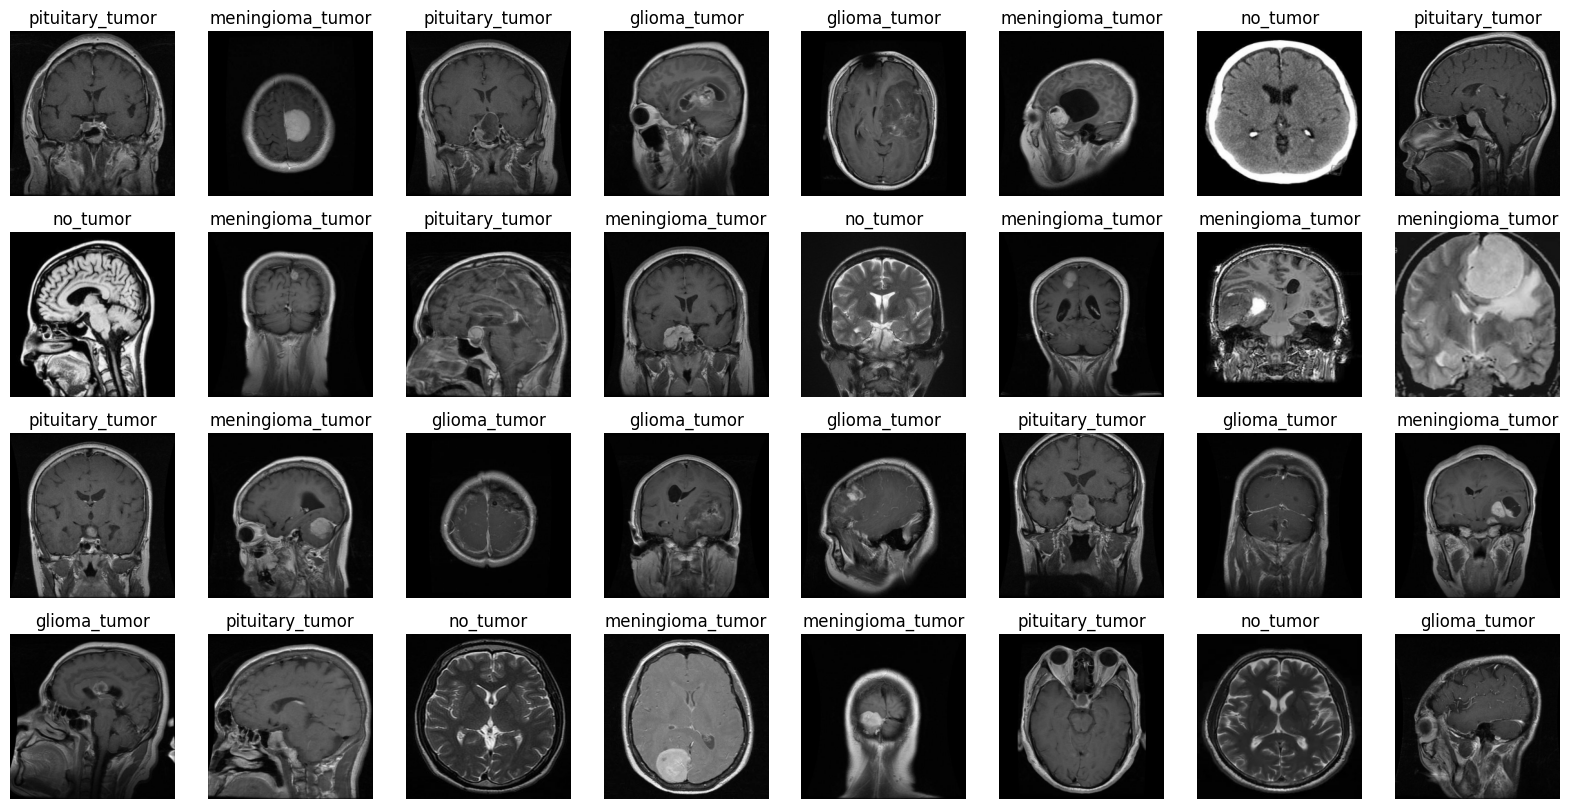

In [36]:
plt.figure(figsize=(20, 10))
i = 1
for image, label in train_dataset.take(1).unbatch():
    image = image.numpy()
    label = main_dataset_labels[np.argmax(label.numpy())]
    plt.subplot(4, 8, i)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    i += 1

In [53]:
def VGG16_based_model():
    base_model = VGG16(
        weights = "imagenet", 
        input_shape = (256, 256, 3),
        include_top = False, 
    )

    base_model.trainable = False

    input = Input((256, 256, 3))
    x = RandomRotation(factor=(-0.2, 0.2))(input)
    x = RandomZoom(height_factor=0.1, width_factor=0.1)(x)
    x = RandomContrast(factor= (0.8, 1.2))(x)
    x = base_model(input, training=False)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    output = Dense(4, activation="linear")(x)
    
    return Model(inputs=input, outputs=output),base_model

In [54]:
model_1, base_models_1 = VGG16_based_model()

In [55]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_4 (Bat  (None, 32768)             131072    
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 1024)              33555456  
                                                                 
 dense_9 (Dense)             (None, 4)                 4100      
                                                           

In [56]:
model_1.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=["accuracy"])

In [57]:
checkpoint_file_path_1 = "./Checkpoints/model_1.keras"
callbacks_1 = [
    EarlyStopping(
        monitor = "val_loss", 
        min_delta = 1e-3, 
        patience = 3,
        start_from_epoch = 10,
        restore_best_weights = True, 
    ),
    ModelCheckpoint(
        filepath = checkpoint_file_path_1,
        monitor = "val_accuracy",
        save_best_only = True,
    )
]

In [58]:
hist_1 = model_1.fit(train_dataset, epochs=5, callbacks=callbacks_1, validation_data=validation_dataset)


Epoch 1/5
72/72 [==============================] - 16s 186ms/step - loss: 5.1791 - accuracy: 0.7770 - val_loss: 2.1583 - val_accuracy: 0.7822
Epoch 2/5
72/72 [==============================] - 13s 179ms/step - loss: 0.8005 - accuracy: 0.9403 - val_loss: 0.9300 - val_accuracy: 0.8101
Epoch 3/5
72/72 [==============================] - 13s 182ms/step - loss: 0.3187 - accuracy: 0.9621 - val_loss: 0.6083 - val_accuracy: 0.8746
Epoch 4/5
72/72 [==============================] - 13s 178ms/step - loss: 0.1521 - accuracy: 0.9800 - val_loss: 0.5251 - val_accuracy: 0.9059
Epoch 5/5
72/72 [==============================] - 11s 149ms/step - loss: 0.1441 - accuracy: 0.9826 - val_loss: 0.7454 - val_accuracy: 0.8972


In [60]:
model_1.evaluate(test_dataset)

13/13 [==============================] - 2s 102ms/step - loss: 17.0443 - accuracy: 0.6980


[17.044340133666992, 0.6979695558547974]

In [61]:
for layer in base_models_1.layers:
    layer.trainable = True

In [62]:
model_1.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(1e-5), metrics=["accuracy"])

In [63]:
hist_1_2 = model_1.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks = callbacks_1)

Epoch 1/10
72/72 [==============================] - 15s 184ms/step - loss: 0.1627 - accuracy: 0.9887 - val_loss: 0.6241 - val_accuracy: 0.9164
Epoch 2/10
72/72 [==============================] - 13s 182ms/step - loss: 0.0995 - accuracy: 0.9874 - val_loss: 0.5519 - val_accuracy: 0.9268
Epoch 3/10
72/72 [==============================] - 13s 181ms/step - loss: 0.0310 - accuracy: 0.9930 - val_loss: 0.5298 - val_accuracy: 0.9321
Epoch 4/10
72/72 [==============================] - 13s 178ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.5056 - val_accuracy: 0.9355
Epoch 5/10
72/72 [==============================] - 11s 152ms/step - loss: 0.0215 - accuracy: 0.9965 - val_loss: 0.5212 - val_accuracy: 0.9338
Epoch 6/10
72/72 [==============================] - 11s 148ms/step - loss: 0.0201 - accuracy: 0.9948 - val_loss: 0.5256 - val_accuracy: 0.9355
Epoch 7/10
72/72 [==============================] - 13s 178ms/step - loss: 0.0088 - accuracy: 0.9956 - val_loss: 0.5408 - val_accuracy: 0.9390

In [64]:
model_1.evaluate(test_dataset)

13/13 [==============================] - 2s 103ms/step - loss: 31.8620 - accuracy: 0.7487


[31.862049102783203, 0.7487309575080872]

In [65]:
model_1.save("MRI_VGG_16_Tuned.keras")
base_models_1.save("MRI_VGG_16_Tuned_Base.keras")

In [66]:
model_1.save_weights("MRI_VGG_16_Tuned.weights.h5")
base_models_1.save_weights("MRI_VGG_16_Tuned_Base.weights.h5")

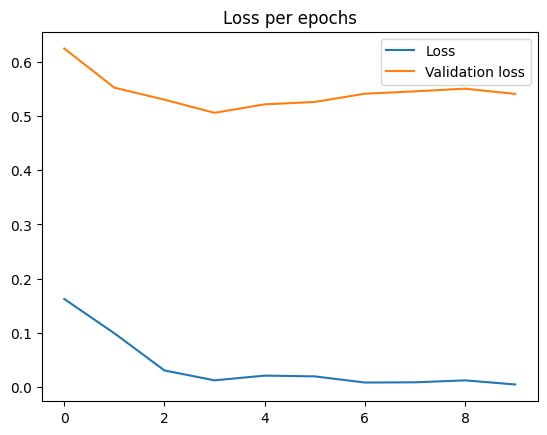

In [67]:
hist = hist_1_2.history
plt.plot(hist["loss"], label="Loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.title("Loss per epochs")
plt.legend()
plt.show()

In [68]:
base_models_1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [69]:
counts = tf.Variable([0, 0, 0, 0], dtype=tf.float32)
for _, label in train_dataset.unbatch().take(-1):
    counts.assign_add(label)

In [70]:
counts

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([669., 652., 317., 658.], dtype=float32)>

In [81]:
def visualize_result(dataset):
    plt.figure(figsize=(20, 12))
    i = 1
    for image, label in dataset.take(1).unbatch().take(32):
        image = image.numpy()
        label = main_dataset_labels[np.argmax(label.numpy())]
        predicted_label = main_dataset_labels[np.argmax(model_1.predict(np.reshape(image, (1,) + image.shape), verbose=False))]
        plt.subplot(4, 8, i)
        plt.imshow(image)
        plt.title(f"Label: {label}\nPredicted: {predicted_label}")
        plt.axis("off")
        i += 1

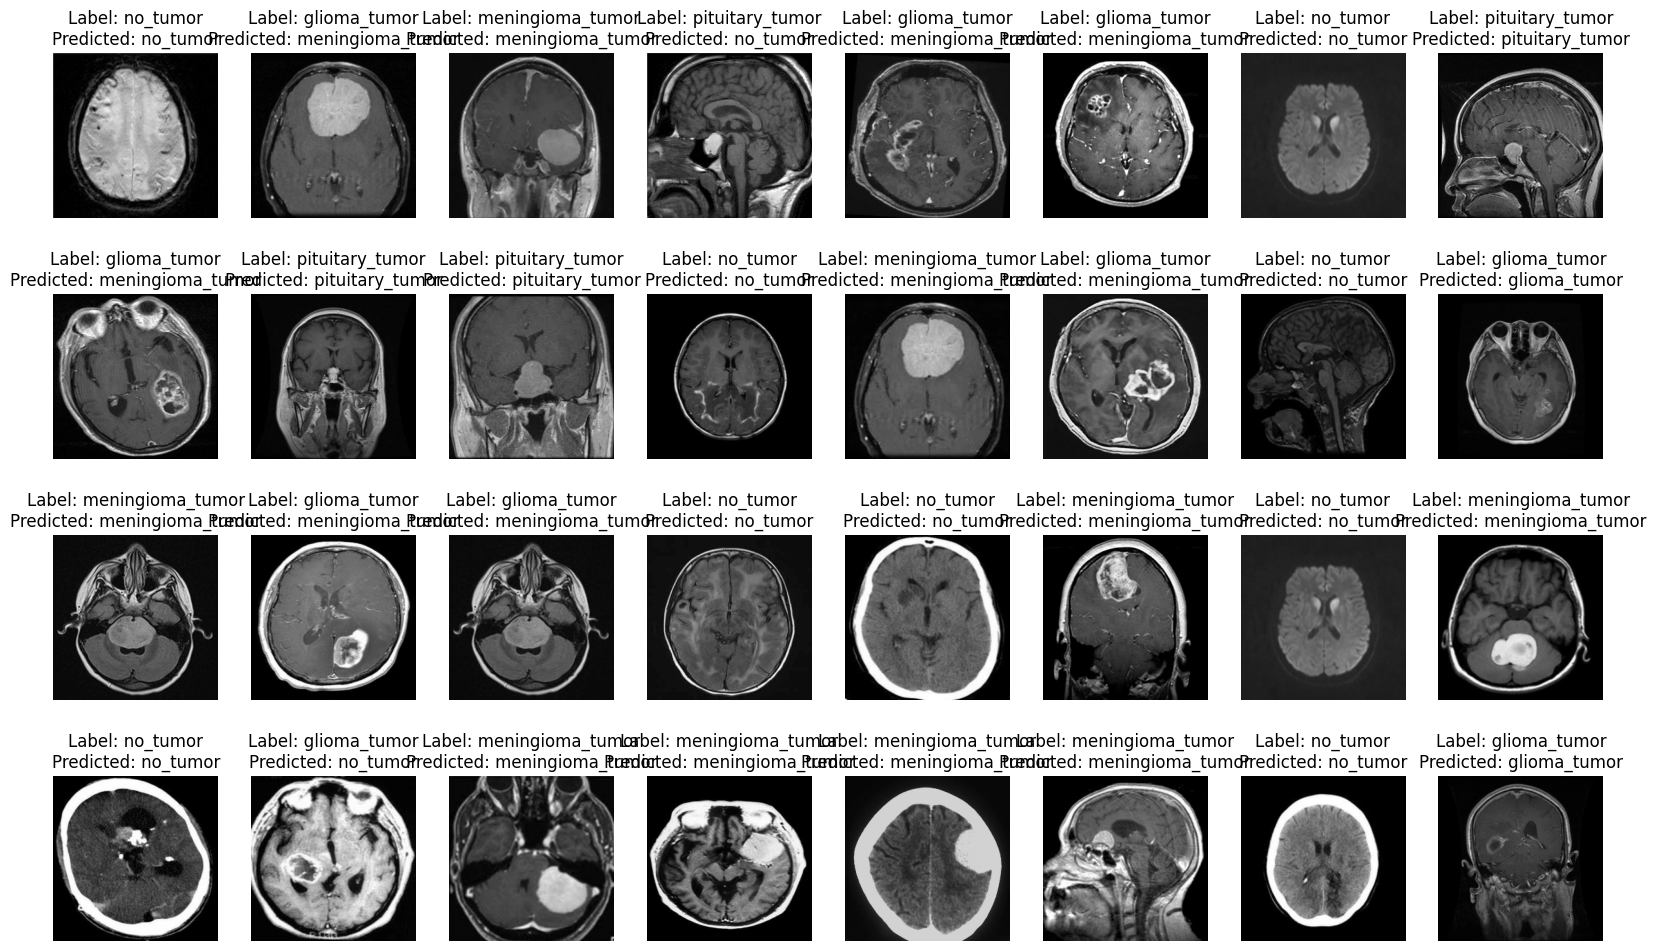

In [82]:
visualize_result(test_dataset)